# Transfer learning with tensdorflow part 2 : Fine tuning 

In [1]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

### Lets get some data 

This time we we look into models which are present in tensorflow applications (tf.keras.applications)

In [2]:
# Get 10% of food 101 data 
# url = 'https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip'
# folder = wget.download(url)
# unzip_data('10_food_classes_10_percent.zip')

In [3]:
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [4]:
# Create training and test directory paths 
train_dir  = '10_food_classes_10_percent/train'
test_dir ='10_food_classes_10_percent/test'

In [5]:
import tensorflow as tf 

IMG_SIZE =(224,224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=BATCH_SIZE,)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [7]:
train_data_10_percent.class_names # type: ignore

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [8]:
# See an eample of a batch of data 

for images,labels in train_data_10_percent.take(1): # type: ignore
    print(images,labels)


tf.Tensor(
[[[[6.31224518e+01 5.41224518e+01 4.51224518e+01]
   [6.31428566e+01 5.71428566e+01 4.51428566e+01]
   [6.04591827e+01 5.64591827e+01 4.44591827e+01]
   ...
   [3.34285278e+01 3.42142639e+01 2.62142639e+01]
   [3.00101795e+01 3.10101795e+01 2.30101795e+01]
   [2.59795628e+01 2.89795628e+01 1.99795628e+01]]

  [[6.31530609e+01 5.45816345e+01 4.47244911e+01]
   [6.35408134e+01 5.75408134e+01 4.55408134e+01]
   [6.29693871e+01 5.90612259e+01 4.67857132e+01]
   ...
   [3.37652702e+01 3.45510063e+01 2.63673534e+01]
   [3.17857018e+01 3.27857018e+01 2.47857018e+01]
   [2.95612106e+01 3.17040672e+01 2.31326389e+01]]

  [[6.53571472e+01 5.73571396e+01 4.63571396e+01]
   [6.54489822e+01 5.94489784e+01 4.74489784e+01]
   [6.69693909e+01 6.31836739e+01 5.05408173e+01]
   ...
   [3.49285507e+01 3.57142868e+01 2.72857571e+01]
   [3.29795876e+01 3.39795876e+01 2.59795876e+01]
   [3.18979492e+01 3.28979492e+01 2.48979492e+01]]

  ...

  [[1.23357155e+02 1.26357155e+02 1.09357155e+02]
   [1

In [9]:
# base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)


## Model 0: Building a tranfer learning model using the Keras functional API

In [10]:
# 1. Create a model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model 
base_model.trainable = False

# 3. Create inputs into our model 
inputs  = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

# 4. Pass the inputs to the base_model
x = base_model(inputs)
print(f'shape after passing inputs through base model:{x.shape}')

# 5. Avergae pooling the outputs of the base model 
# x = tf.keras.layers.GlobalAvgPool2D(name = 'global_average_pooling')
# print(f'shape after GlobalAveragePooling2D:{x.shape}')

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 6. Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation='softmax',name='output_layer')(x)

# 7. Combine the inputs and outputs into a model 
model_0 = tf.keras.Model(inputs,outputs)

# 8. Compile the model 
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics =['accuracy'])

# 9. fit the model
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25*len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name='tranfer_learning',
                                                                        experiment_name='10_percent_feature_extraction')])


shape after passing inputs through base model:(None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: tranfer_learning/10_percent_feature_extraction/20240616-203949
Epoch 1/5
24/24 [==============================] - 8s 136ms/step - loss: 1.9319 - accuracy: 0.3907 - val_loss: 1.3541 - val_accuracy: 0.7237
Epoch 2/5
24/24 [==============================] - 2s 83ms/step - loss: 1.1796 - accuracy: 0.7293 - val_loss: 0.9129 - val_accuracy: 0.7961
Epoch 3/5
24/24 [==============================] - 2s 84ms/step - loss: 0.8551 - accuracy: 0.7973 - val_loss: 0.7377 - val_accuracy: 0.8405
Epoch 4/5
24/24 [==============================] - 2s 85ms/step - loss: 0.7088 - accuracy: 0.8400 - val_loss: 0.6253 - val_accuracy: 0.8602
Epoch 5/5
24/24 [==============================] - 2s 85ms/step - loss: 0.6084 - accuracy: 0.8653 - val_loss: 0.5660 - val_accuracy: 0.8602


In [11]:
# Evaluate on the full test dataset 
model_0.evaluate(test_data)

79/79 [==============================] - 4s 47ms/step - loss: 0.5870 - accuracy: 0.8500


[0.5869829654693604, 0.8500000238418579]

In [12]:
for layer_number,layer in enumerate(base_model.layers):
    print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [13]:
# summary of base model 
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   0           ['rescaling[0][0]']              
                                3)                                                

In [14]:
# summary of model 0
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


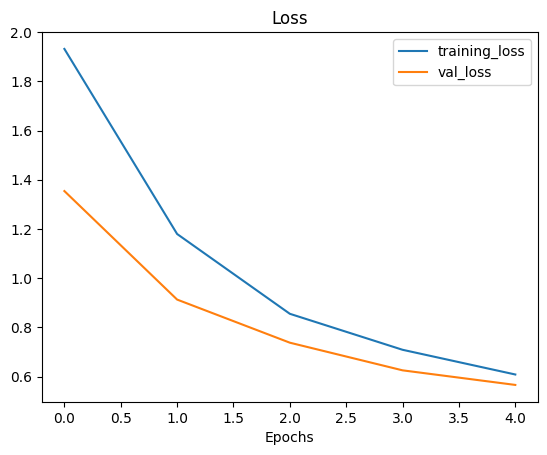

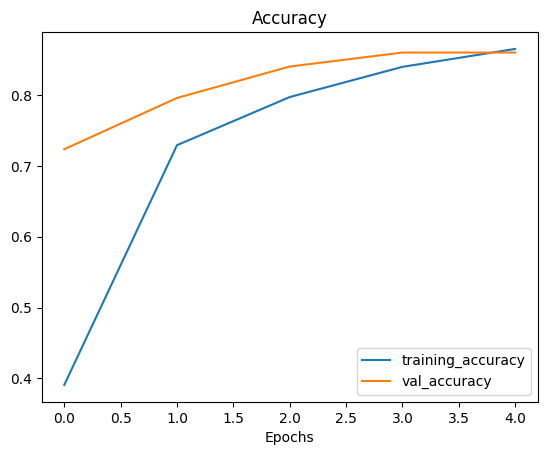

In [15]:
# Check out our models training curves 
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model 

Lets demonstrate the Global Average Pooling 2D layer.
We have a tensor after our model goes through base_model of shape(None,7,7,1280).
But then when it passes through GlobalAveragePooling2D , it turns into (None,1280).
Lets use a simialr shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D

In [16]:
# Define the input shape
input_shape =(1,4,4,3)

# create a random tensor 
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor :\n{input_tensor}\n')

# Pass the random tensor through a global pooling 2D layer 
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D global average pooled random tensor:\n{global_average_pooled_tensor}')
# check the shape of differnt tensors
print(f'Shape of input tensor:{input_tensor.shape}')
print(f'Shape of global average pooling 2D{global_average_pooled_tensor.shape}')

Random input tensor :
[[[[ 0.3274686  -0.8426257   0.31943342]
   [-1.4075519  -2.3880594  -1.039248  ]
   [-0.55732316  0.53970677  1.6994323 ]
   [ 0.28893653 -1.5066113  -0.26454788]]

  [[-0.59722424 -1.9171128  -0.62044096]
   [ 0.8504024  -0.40604675 -3.025841  ]
   [ 0.9058464   0.29855967 -0.2256155 ]
   [-0.76164424 -1.8917137  -0.9384714 ]]

  [[ 0.778522   -0.4733888   0.97772676]
   [ 0.24694404  0.20573732 -0.52562314]
   [ 0.32410017  0.02545412 -0.10638462]
   [-0.63694745  1.160312    0.25073585]]

  [[-0.41728505  0.40125757 -1.4145439 ]
   [-0.59318614 -1.6617215   0.335671  ]
   [ 0.10815619  0.2347966  -0.5666874 ]
   [-0.3581984   0.8869861   0.52744746]]]]

2D global average pooled random tensor:
[[-0.09368651 -0.4584043  -0.28855985]]
Shape of input tensor:(1, 4, 4, 3)
Shape of global average pooling 2D(1, 3)


## Running a series of tranfer learning experiments 

1. **model_1** - use feature etraction transfer learning with 1% of training data with data augmentation 
2. **model_2** - use feature extraction tranfer learning with 10% of training data with data augmentation 
3. **model_3** - use fine-tuning tranfer learning on 10 % of the training data with data augmentation 
4. **model-4** - use fine-tuning tranfer learning on 100% of the training data with data augmentation 

In [17]:
# import wget
# url = 'https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip'

# folder = wget.download(url)

In [18]:
# unzip_data('10_food_classes_1_percent.zip')

In [19]:
# Create traiing and test dirs 
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [20]:
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

### Getting and preprocessing data for model_1

In [21]:
# Setup data loaders 
IMG_size =(224,224)
# BATCH_SIZE =32
train_data_1_percent =tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                          label_mode ='categorical',
                                                                          image_size = IMG_SIZE,
                                                                          batch_size = BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model 

To add data augmentaion right into our models , we can use the layers inside:
* tf.keras.layers.experimental.preprocessing()

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # type: ignore
from tensorflow.keras.layers.experimental import preprocessing # type: ignore

# Create data augmentation stage with horizontal flipping , rotations,zooms , etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1/255)  #keep for models like Resnet50v2 
],name='data_augmentation')

In [23]:
# training=True
# augmented_img = data_augmentation(img)
# augmented_img = data_augmentation(img, training=True)

### Visualize our data augmentation 

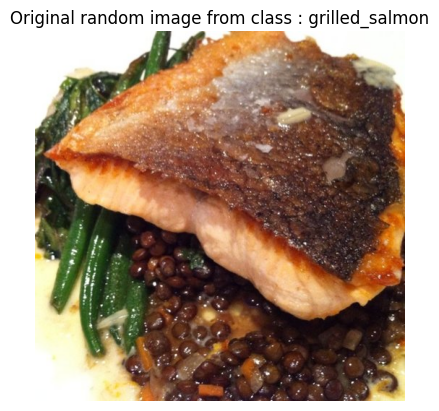

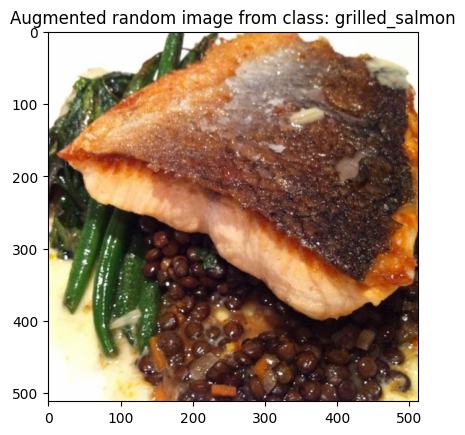

In [24]:
# view a ranodm image and compare it to its augmented version

import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import os 
import random
target_class = random.choice(train_data_1_percent.class_names) # type: ignore
target_dir = '10_food_classes_1_percent/train/' + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = random.choice(os.listdir(target_dir))
random_image_path =target_dir + '/' + random_image

# Read in the random image 
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'Original random image from class : {target_class}')
plt.axis(False)

# print(target_dir)
# Now lets plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img,axis =0))
plt.figure()
plt.title(f'Augmented random image from class: {target_class}')
plt.imshow(tf.squeeze(augmented_img)/255.)

## Model 1 : Feature extraction transfer learning on 1% of the data with data augmentation  

In [25]:
input_shape =(224,224,3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input layer 
inputs = layers.Input(shape=input_shape,name='input_layer')

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs and dont train it 
x = base_model(x,training =False)

# Pool output features of the base model 
x = layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)

# put a dense layer on as the output
outputs =layers.Dense(10,activation ='softmax',name ='output_layer')(x)

# make a model using the inputs and outputs 
model_1 = keras.Model(inputs,outputs)

# Compile the model 
model_1.compile(loss ='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
# Fit the model 
history_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=(0.25*len(test_data)),
                        # Track model training logs
                        callbacks=[create_tensorboard_callback(dir_name='tranfer_learning',
                                                               experiment_name='1_percent_data_aug')])


Saving TensorBoard log files to: tranfer_learning/1_percent_data_aug/20240616-204013
Epoch 1/5
3/3 [==============================] - 8s 1s/step - loss: 2.3228 - accuracy: 0.1143 - val_loss: 2.3018 - val_accuracy: 0.1266
Epoch 2/5
3/3 [==============================] - 2s 687ms/step - loss: 2.1174 - accuracy: 0.1857 - val_loss: 2.1814 - val_accuracy: 0.2047
Epoch 3/5
3/3 [==============================] - 2s 720ms/step - loss: 1.9247 - accuracy: 0.3429 - val_loss: 2.0721 - val_accuracy: 0.2672
Epoch 4/5
3/3 [==============================] - 2s 700ms/step - loss: 1.8456 - accuracy: 0.4286 - val_loss: 1.9830 - val_accuracy: 0.3187
Epoch 5/5
3/3 [==============================] - 2s 664ms/step - loss: 1.6781 - accuracy: 0.5429 - val_loss: 1.8862 - val_accuracy: 0.3875


In [26]:
# check out the models summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [27]:
# evaluate on the full test dataset 
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 4s 45ms/step - loss: 1.8630 - accuracy: 0.4080


[1.8629590272903442, 0.40800002217292786]

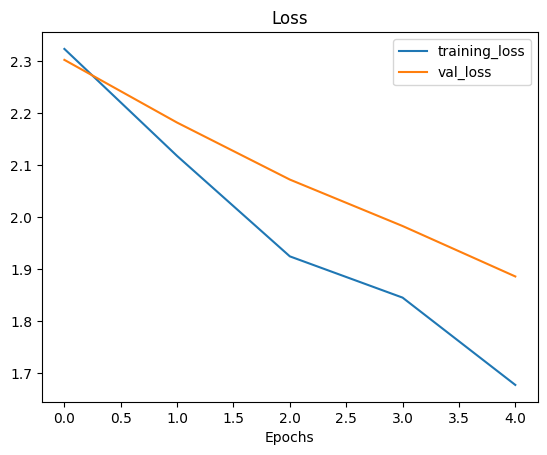

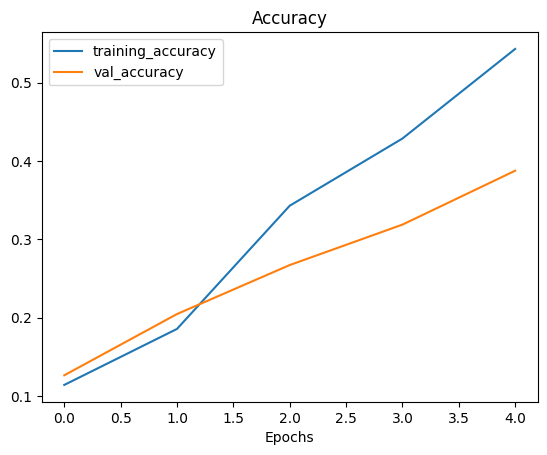

In [28]:
# how does the model loss curves goes 
plot_loss_curves(history_1)

## Model 2 feature extraction transfer learning model with 10 % of data and data augmentation 

In [29]:
train_dir_10_percent = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [30]:
# Set data inputs 
IMG_SIZE = (224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode ='categorical',
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [31]:
from tensorflow.keras import layers # type: ignore
from tensorflow.keras.layers.experimental import preprocessing # type: ignore
from tensorflow.keras.models import Sequential # type: ignore


# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
],name ='data_augmentation')

# Setup the input shape to our model 
input_shape = (224,224,3)

# create a frozen model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# create the inputs and outputs 
inputs = layers.Input(shape =input_shape,name='input_layer')
x = data_augmentation(inputs)
x = base_model(x,training =False) 
x = layers.GlobalAveragePooling2D(name ='global_average_pooling_2D')(x)

outputs = layers.Dense(10,activation = 'softmax' ,name ='output_layer')(x)
model_2 = tf.keras.Model(inputs,outputs)

#Compile the model 
model_2.compile(loss ='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


In [32]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

### Creating a modelCheckpoint callback
 

In [33]:
checkpoint_path = 'ten_percent_model_checkpoints_weights/checkpoint.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                   save_weights_only=True,
                                   save_best_only=False,
                                   save_freq='epoch',
                                   verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [34]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks= [create_tensorboard_callback(dir_name='tranfer_learning',
                                                                                  experiment_name='10_percent_data_aug'),
                                                                                  checkpoint_callback])

Saving TensorBoard log files to: tranfer_learning/10_percent_data_aug/20240616-204034
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0480 - accuracy: 0.3373
Epoch 1: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 18s 511ms/step - loss: 2.0480 - accuracy: 0.3373 - val_loss: 1.5162 - val_accuracy: 0.6168
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3982 - accuracy: 0.6533
Epoch 2: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 13s 532ms/step - loss: 1.3982 - accuracy: 0.6533 - val_loss: 1.0807 - val_accuracy: 0.7533
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1020 - accuracy: 0.7307
Epoch 3: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 13s 530ms/step - loss: 1.1020 - accuracy: 0.7307 - val_loss: 0.8817 - val_accuracy: 0.7977
Ep

In [35]:
# model_0 results 
model_0.evaluate(test_data)

79/79 [==============================] - 5s 50ms/step - loss: 0.5870 - accuracy: 0.8500


[0.5869826078414917, 0.8500000238418579]

In [36]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 4s 50ms/step - loss: 0.6545 - accuracy: 0.8364


[1.8629590272903442, 0.40800002217292786]

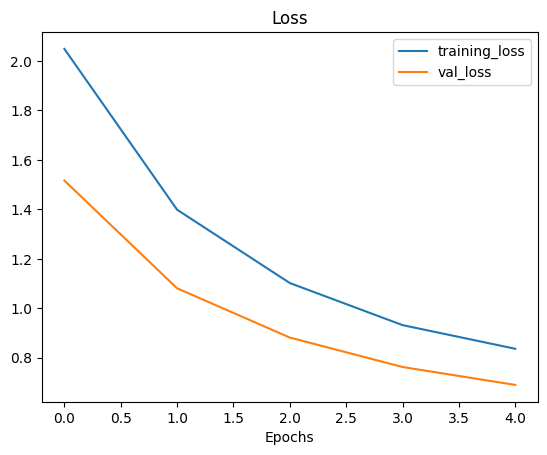

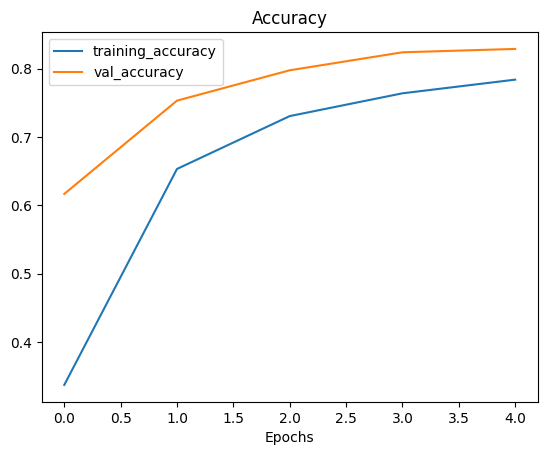

In [37]:
# plot model loss curves 
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights 

Loading in checkpointed weights and evaluate model

In [38]:
# Load in saved models weights and evaluate model
model_2.load_weights(checkpoint_path)

In [39]:
# Evaluate model_2 with loaded weights 
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 4s 50ms/step - loss: 0.6545 - accuracy: 0.8364


In [40]:
results_10_percent_data_aug == loaded_weights_model_results

False

results_10_percent_data_aug

In [41]:
results_10_percent_data_aug

[0.6545180678367615, 0.836400032043457]

In [42]:
loaded_weights_model_results

[0.6545181274414062, 0.836400032043457]

## Model 3 : Fne tuning an existing model on 10% of the data 

In [43]:
model_2.layers

In [44]:
for layer in model_2.layers:
    print(layer,layer.trainable)


<keras.engine.input_layer.InputLayer object at 0x00000221AEFEEB50> True
<keras.engine.sequential.Sequential object at 0x00000221599383A0> True
<keras.engine.functional.Functional object at 0x00000221AF01E940> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x0000022156623040> True
<keras.layers.core.dense.Dense object at 0x00000221AEFF4F10> True


In [45]:
for i,layer in enumerate(model_2.layers[2].layers):
    print(i,layer.name,layer.trainable)


0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [46]:
base_model.trainable =True

# freeze all the layers for the last  10 layers

for  layer in base_model.layers[:-10]:
    layer.trainable =False

In [47]:
# Recomile 
model_2.compile(loss = 'categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])



In [48]:
# check which layers are tunable 

for layer_number , layer in enumerate(model_2.layers[2].layers):
    print(layer_number,layer.name,layer.trainable)
    

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [49]:
print(len(model_2.trainable_variables))

12


In [50]:
# Fine tune for another 5 epochs 
fine_tune_epochs = initial_epochs + 5

# Refit the model 
history_fine_10_percent_data_aug = model_2.fit(train_data_1_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25*len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1],
                                               callbacks=[create_tensorboard_callback(dir_name= 'tranfer_learning',
                                                                                      experiment_name='10_percent_fine_tune_last_10' )])

Saving TensorBoard log files to: tranfer_learning/10_percent_fine_tune_last_10/20240616-204159


Epoch 5/10
3/3 [==============================] - 15s 2s/step - loss: 0.8173 - accuracy: 0.7857 - val_loss: 0.6690 - val_accuracy: 0.8388
Epoch 6/10
3/3 [==============================] - 3s 939ms/step - loss: 0.7428 - accuracy: 0.8000 - val_loss: 0.6552 - val_accuracy: 0.8454
Epoch 7/10
3/3 [==============================] - 2s 712ms/step - loss: 0.7085 - accuracy: 0.7714 - val_loss: 0.6275 - val_accuracy: 0.8454
Epoch 8/10
3/3 [==============================] - 2s 655ms/step - loss: 0.6341 - accuracy: 0.8571 - val_loss: 0.6327 - val_accuracy: 0.8339
Epoch 9/10
3/3 [==============================] - 2s 758ms/step - loss: 0.6484 - accuracy: 0.8286 - val_loss: 0.6022 - val_accuracy: 0.8438
Epoch 10/10
3/3 [==============================] - 2s 879ms/step - loss: 0.5960 - accuracy: 0.8429 - val_loss: 0.5883 - val_accuracy: 0.8438


In [51]:
# Evaluate the fine tuned model
results_fine_tune_10_percent  =  model_2.evaluate(test_data)

79/79 [==============================] - 4s 52ms/step - loss: 0.5868 - accuracy: 0.8364


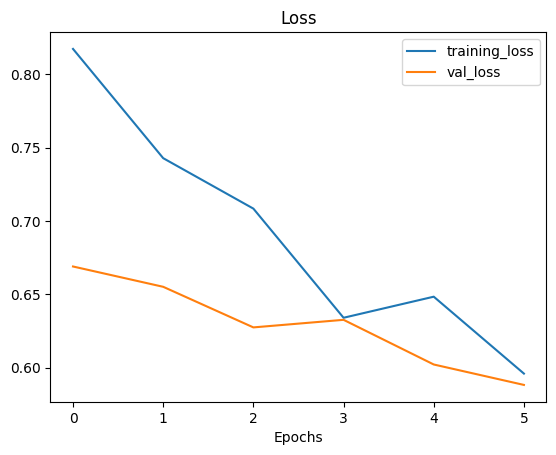

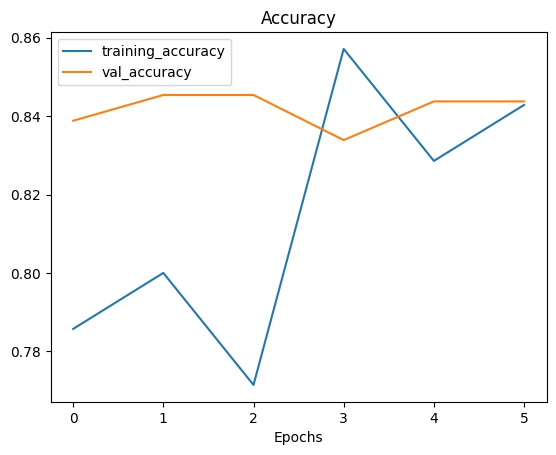

In [52]:
plot_loss_curves(history_fine_10_percent_data_aug)

In [53]:
# lets create a function 

def compare_history(original_history ,new_history , initial_epochs =5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.3373333215713501, 0.653333306312561, 0.7306666374206543, 0.7639999985694885, 0.7839999794960022, 0.7857142686843872, 0.800000011920929, 0.7714285850524902, 0.8571428656578064, 0.8285714387893677, 0.8428571224212646]


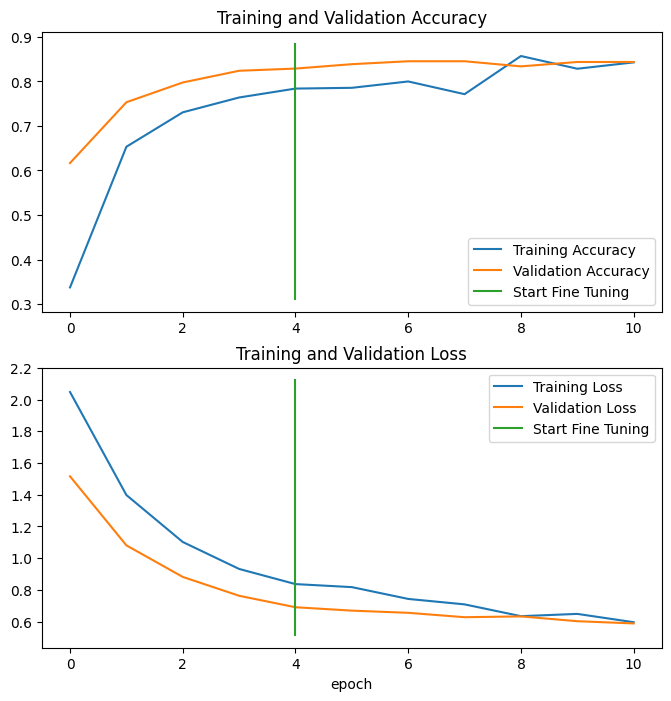

In [54]:
compare_history(history_10_percent_data_aug,history_fine_10_percent_data_aug,initial_epochs=5)

## Model 4 : Fine tuning and existing model with 100% of data 

In [55]:
# setup training and test dir 

train_dir_all_data = '10_food_classes_all_data/train'
test_dir= '10_food_classes_all_data/test'

In [56]:
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

In [57]:
IMG_SIZE = (224,224)

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode='categorical',
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE)



Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


To train a fine tuning model we need to revert model 2 back to its feature extraction weights 

In [58]:
model_2.load_weights(checkpoint_path)

In [59]:
# lets evaluate model 2 

model_2.evaluate(test_data)

79/79 [==============================] - 5s 58ms/step - loss: 0.6545 - accuracy: 0.8364


[0.6545181274414062, 0.836400032043457]

In [60]:
results_10_percent_data_aug

[0.6545180678367615, 0.836400032043457]

Alright the previous steps might be confusing but all we've done is :

1. Trained a feature extraction tranfe learning model for 5 epochs on 10% of the data augmentation and we saved the models weights using 'ModelCheckpoint' callback
2. fine tuned the same model with the top 10 layers of the base model unfrozen
3. saved the results and training logs each time 
4. Reloaded the model from step 1 to do the same steps as steps  expecct this time we're going to use all 100% of data  


In [61]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 True
3 global_average_pooling_2D True
4 output_layer True


In [62]:
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

In [63]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [64]:
# Compile 
model_2.compile(loss = 'categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])


In [65]:
# Continue to train and fine tune the model to our data 

fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps= (0.25*len(test_data)),
                                           initial_epoch=history_fine_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                 experiment_name= 'Full_10_classes_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/Full_10_classes_fine_tune_last_10/20240616-204237
Epoch 10/10
235/235 [==============================] - 738s 3s/step - loss: 0.7226 - accuracy: 0.7692 - val_loss: 0.3560 - val_accuracy: 0.8844


In [66]:

results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

 4/79 [>.............................] - ETA: 3s - loss: 0.4509 - accuracy: 0.8516

79/79 [==============================] - 4s 48ms/step - loss: 0.3640 - accuracy: 0.8820


[0.3640213906764984, 0.8820000290870667]

5
6
[0.3373333215713501, 0.653333306312561, 0.7306666374206543, 0.7639999985694885, 0.7839999794960022, 0.7692000269889832]


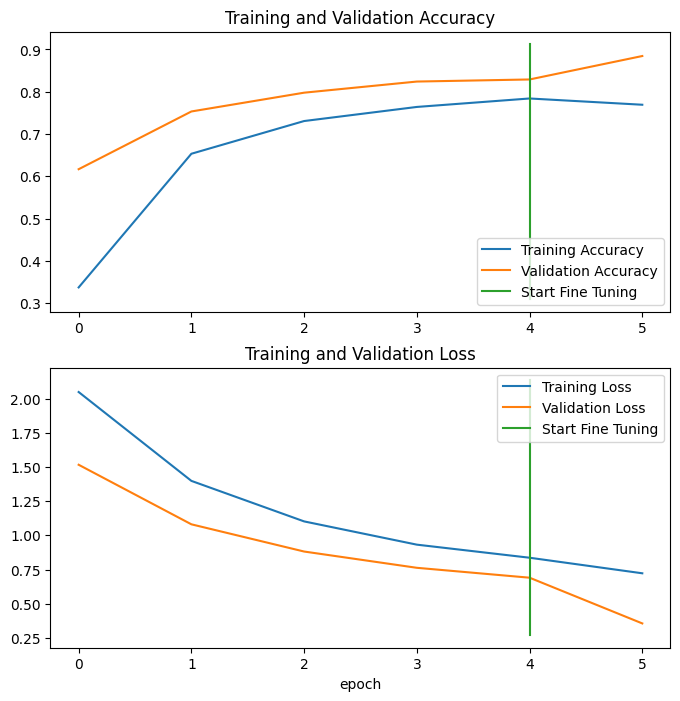

In [67]:
compare_history(history_10_percent_data_aug,history_fine_10_classes_full,initial_epochs=5)